## Extract features for sepsis patients received mechanical ventilation. Some tables are obtained by running the official GitHub repo.

In [13]:
#libraries
import numpy as np
import pandas as pd
import psycopg2 #used to connect to our local MIMIC-III database
import collections
# import getpass
from datetime import datetime
import os,sys,re
import pickle
import csv
import math
#import seaborn as sns
# import random
from datetime import timedelta
from pathlib import Path
import importlib
import bisect
import glob
import copy


from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

#%load_ext autotime

{'width': 1024, 'height': 768, 'scroll': True}

In [14]:
dbname = 'mimiciv'
password = '15289943821'
user = 'postgres'
conn = psycopg2.connect(dbname=dbname, password=password,user=user,port=5433)
cur=conn.cursor()

## See MIMICIV-Coag for creating derived tables "pivoted_lab" and "patient_info"

### Select sepsis cohort

In [21]:
query_cohort = '''

select * from patient_info where stay_id in (select distinct stay_id from public.chartevents where itemid = 224684 ) 
and stay_id in (select distinct stay_id from sepsis3)
'''

    
query_pivoted_lab = '''
select * from public.pivoted_lab where stay_id is not null
'''

sql_statement = '''
select * from (
with ss as (
'''\
+ query_cohort + ' ),  pvl as (' \
+ query_pivoted_lab + ') '\
+'''
select pvl.subject_id as subject_id, ss.stay_id as stay_id, 
ss.age as age, ss.is_male as is_male, ss.is_black as is_black,  ss.is_white 
as is_white, ss.is_hispanic as is_hispanic, ss.is_ASIAN as is_ASIAN, ss.is_OTHER as is_OTHER,ss.weight as weight, 
pvl.charttime as pvl_charttime, pvl.aniongap as aniongap, pvl.albumin as albumin, 
pvl.bicarbonate as bicarbonate,  pvl.creatinine as creatinine,pvl.chloride as chloride,
pvl.hematocrit as hematocrit,pvl.hemoglobin as hemoglobin,
pvl.platelet as platelet,pvl.potassium as potassium,pvl.ptt as ptt,pvl.inr as inr,pvl.pt as pt,
pvl.sodium as sodium,pvl.bun as bun,pvl.wbc as wbc 
from ss join  pvl on ss.stay_id=pvl.stay_id
) cohort 

''' 



ppt_df = pd.read_sql_query(sql_statement,conn) 
ppt_df

,subject_id,stay_id,age,is_male,is_black,is_white,is_hispanic,is_asian,is_other,weight,...,hematocrit,hemoglobin,platelet,potassium,ptt,inr,pt,sodium,bun,wbc
0,12350277,37120579,65,1,0,1,0,0,0,112.000000,...,NaN,NaN,NaN,4.1,NaN,NaN,NaN,137.0,119.0,NaN
1,12664423,36850243,79,1,0,1,0,0,0,130.500000,...,NaN,NaN,NaN,NaN,27.5,1.2,13.2,NaN,NaN,NaN
2,16175244,36032605,32,1,0,1,0,0,0,82.200000,...,NaN,NaN,NaN,4.2,NaN,NaN,NaN,143.0,30.0,NaN
3,14722153,31061325,82,0,0,1,0,0,0,61.766667,...,27.6,8.7,275.0,NaN,NaN,NaN,NaN,NaN,NaN,25.9
4,16479004,37059308,42,1,0,0,0,0,1,98.300000,...,NaN,NaN,NaN,4.2,NaN,NaN,NaN,133.0,23.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893767,11415226,34576630,58,1,0,0,0,0,1,44.300000,...,NaN,NaN,NaN,NaN,32.0,1.5,16.4,NaN,NaN,NaN
893768,16026167,35421239,67,1,0,1,0,0,0,104.600000,...,NaN,NaN,NaN,NaN,34.0,1.9,20.8,NaN,NaN,NaN
893769,12009817,39155795,73,1,1,0,0,0,0,80.500000,...,NaN,NaN,NaN,NaN,45.2,NaN,NaN,NaN,NaN,NaN
893770,13508515,38370015,73,1,0,1,0,0,0,142.800000,...,NaN,NaN,NaN,NaN,56.5,NaN,NaN,NaN,NaN,NaN


In [22]:
def median_impute(df, columns):
    # df has column stay_id
    for col in columns:
        median = df[col].dropna(how='any').median() # global median
        stay_median = {}
        for stay,val in zip(df['stay_id'], df[col]):
            if stay not in stay_median:
                stay_median[stay] = []
            if not math.isnan(float(val)):
                stay_median[stay].append(float(val))
        stay_median1 = {}
        for i in stay_median:
            vals = stay_median[i]
            if len(vals) == 0:
                stay_median1[i] = median # global median
            else:
                stay_median1[i] = np.median(vals) # local median
        new_values = []
        for stay,val in zip(df['stay_id'], df[col]):
            if math.isnan(float(val)):
                new_values.append(stay_median1[stay])
            else:
                new_values.append(float(val))
        df[col] = new_values
    return df

def datetime_to_sec(df,time_col='charttime'):
    time_in_sec = []
    date_format = '%Y-%m-%d %H:%M:%S'
    for i in df[time_col]:
        time_in_sec.append(datetime.strptime(str(i),date_format).timestamp())
    df[time_col] = time_in_sec
    return df

def datetime_to_sec_entry(time):
    date_format = '%Y-%m-%d %H:%M:%S'
    return datetime.strptime(str(time),date_format).timestamp()

In [23]:
ppt_df = datetime_to_sec(ppt_df, time_col='pvl_charttime')
columns = ['aniongap', 'albumin','bicarbonate','creatinine','chloride', 'hematocrit',\
          'hemoglobin', 'platelet', 'potassium', 'ptt', 'inr', 'pt', 'sodium', 'bun', 'wbc'] # drop glucose
ppt_df = median_impute(ppt_df, columns)
ppt_df

,subject_id,stay_id,age,is_male,is_black,is_white,is_hispanic,is_asian,is_other,weight,...,hematocrit,hemoglobin,platelet,potassium,ptt,inr,pt,sodium,bun,wbc
0,12350277,37120579,65,1,0,1,0,0,0,112.000000,...,27.70,9.30,65.0,4.10,30.80,1.40,15.80,137.0,119.0,7.90
1,12664423,36850243,79,1,0,1,0,0,0,130.500000,...,27.50,8.70,231.5,4.10,27.50,1.20,13.20,135.0,16.0,13.25
2,16175244,36032605,32,1,0,1,0,0,0,82.200000,...,23.90,7.70,139.0,4.20,41.90,1.50,16.70,143.0,30.0,25.60
3,14722153,31061325,82,0,0,1,0,0,0,61.766667,...,27.60,8.70,275.0,4.10,64.50,1.20,13.40,137.0,63.0,25.90
4,16479004,37059308,42,1,0,0,0,0,1,98.300000,...,24.65,8.10,34.0,4.20,72.20,5.45,57.70,133.0,23.0,11.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893767,11415226,34576630,58,1,0,0,0,0,1,44.300000,...,30.15,9.55,374.5,3.80,32.00,1.50,16.40,145.0,20.0,7.15
893768,16026167,35421239,67,1,0,1,0,0,0,104.600000,...,30.40,8.60,155.0,4.00,34.00,1.90,20.80,145.0,27.0,8.50
893769,12009817,39155795,73,1,1,0,0,0,0,80.500000,...,23.65,7.40,146.0,4.55,45.20,1.30,14.50,144.0,70.5,16.80
893770,13508515,38370015,73,1,0,1,0,0,0,142.800000,...,33.75,10.60,173.5,4.20,56.50,1.20,13.25,135.0,28.0,14.85


### Extract vital signs and impute

In [24]:
def feature_dict(df, feature_start=2, stay=0, time=1):
    result = {}
    n = len(df)
    for i in range(n):
        row = list(df.iloc[i])
        stay_id = row[stay]
        charttime = row[time]
        features = row[feature_start:]
        if stay_id not in result:
            result[stay_id] = {}
        result[stay_id][charttime] = features
    return result 

file = './vital_df.pickle'
if os.path.exists(file):
    file = open(file,'rb')
    vital_dict = pickle.load(file) # {'stay_id:{charttime1:[features], charttime2:[features]}'}
else:    
    stay_id = []
    for i in ppt_df['stay_id']:
        stay_id.append(int(i))


    query_vital = '''
    select stay_id, charttime, heart_rate, sbp,dbp,mbp,resp_rate,temperature,spo2,glucose 
    from public.vitalsign where stay_id in (select distinct stay_id from sepsis3)
    ''' 
    vital_df = pd.read_sql_query(query_vital,conn) 
    exclude = []
    row = 0
    for i in vital_df['stay_id']:
        if int(i) not in stay_id:
            exclude.append(row)
        row += 1
    vital_df.drop(exclude) # [stay_id, charttime, 'heart_rate', 'sbp','dbp','mbp','resp_rate','temperature','spo2','glucose']
    columns = ['heart_rate', 'sbp','dbp','mbp','resp_rate','temperature','spo2','glucose']
    vital_df = median_impute(vital_df,columns)
    vital_df = datetime_to_sec(vital_df)
    vital_dict = vital_df = feature_dict(vital_df, feature_start=2) # {'stay_id:{charttime1:[features], charttime2:[features]}'}
    file = open(file,"wb")
    pickle.dump(vital_dict, file)
    del vital_df

### Convert lab DF into dictionary

In [25]:
stay_start = {}
for i,j in zip(ppt_df['stay_id'], ppt_df['pvl_charttime']):
    if i not in stay_start:
        stay_start[i] = []
    stay_start[i].append(j)
for i in stay_start:
    stay_start[i] = min(stay_start[i])

columns = ['subject_id','stay_id', 'pvl_charttime','age', 'is_male', 'is_black',  'is_white',\
            'is_asian','is_hispanic', 'is_other',  'weight', \
           'aniongap', 'albumin','bicarbonate','creatinine',\
           'chloride', 'hematocrit','hemoglobin', 'platelet', 'potassium', 'ptt', 'inr', 'pt', \
           'sodium', 'bun', 'wbc']
ppt_dict = ppt_df = feature_dict(ppt_df[columns], feature_start=3, stay=1, time=2) # [subject_id, stay_id, hadm_id,...]
# {'stay_id:{charttime1:[features], charttime2:[features]}'}

## Merge lab and vital signs

In [31]:
structural_features= {} # {'stay_id:{charttime1:[features], charttime2:[features]}'}
for stay in stay_start:
    start = stay_start[stay]
    lab_times = sorted(ppt_dict[stay].keys())
    temp = {}
    for vital_time in vital_dict[stay]:
        idx = bisect.bisect_left(lab_times, vital_time) - 1
        if idx < 0:
            continue
        lab_time = lab_times[idx]
        merged_features = copy.deepcopy(ppt_dict[stay][lab_time])
        merged_features.extend(vital_dict[stay][vital_time])
        temp[vital_time] = merged_features
    if len(temp) == 0:
        continue
    else:
        structural_features[stay] = temp

#del ppt_dict
#del vital_dict

## Extract treatment

In [29]:
file = './treatment.pickle'
if os.path.exists(file): #os.path.exists(file)
    file = open(file,'rb')
    treatment_dict = pickle.load(file) #  {stay_id:{time1:dosage1, time2:dosage2}}
else:
    treatment_query = '''
    select distinct ce.stay_id, ce.starttime, ce.dosage_ml_kg from (
    select distinct ce.stay_id, ce.charttime as starttime, (ce.valuenum / w.weight) as dosage_ml_kg 
    from public.chartevents ce join public.first_day_weight w on ce.stay_id = w.stay_id 
    where ce.itemid = 224684 and ce.valuenum is not null and w.weight is not null) ce join
    (select stay_id, starttime, endtime from public.ventilation where ventilation_status = 'InvasiveVent') mv on
    ce.stay_id = mv.stay_id and mv.starttime <= ce.starttime and  mv.endtime >= ce.starttime
    '''
    treatment_df = pd.read_sql_query(treatment_query,conn)
    treatment_dict = {}
    n = len(treatment_df)
    for i in range(n):
        stay_id, time, amount = list(treatment_df[['stay_id', 'starttime', 'dosage_ml_kg']].iloc[i])
        if stay_id not in stay_start:
            continue
        else:
            if stay_id not in treatment_dict:
                treatment_dict[stay_id] = {}
            treatment_dict[stay_id][datetime_to_sec_entry(time)] = amount
    del treatment_df
    file = open(file,"wb")
    pickle.dump(treatment_dict, file)

## Extract outcome

In [27]:
file = './outocmes.pickle'
if os.path.exists(file): #os.path.exists(file)
    file = open(file,'rb')
    outcome_dict = pickle.load(file) #  {stay_id:{time1:SAS1, time2:SAS2}}
else:
    outcome_query = ''' 

select * from (
with co as
(select icu.subject_id, icu.stay_id, vent.starttime - interval '1' day as starttime,
 vent.starttime + interval '2' hour as endtime from
 public.icustays icu join public.ventilation vent on icu.stay_id = vent.stay_id
 where  vent.ventilation_status = 'InvasiveVent'
)

,
s2 as (

  select co.stay_id, ce.CHARTTIME
    -- pre-process the FiO2s to ensure they are between 21-100%
    , max(
        case
          when itemid = 223835
            then case
              when valuenum > 0 and valuenum <= 1
                then valuenum * 100
              -- improperly input data - looks like O2 flow in litres
              when valuenum > 1 and valuenum < 21
                then null
              when valuenum >= 21 and valuenum <= 100
                then valuenum
              else null end -- unphysiological
        when itemid in (3420, 3422)
        -- all these values are well formatted
            then valuenum
        when itemid = 190 and valuenum > 0.20 and valuenum < 1
        -- well formatted but not in %
            then valuenum * 100
      else null end
    ) as fio2_chartevents
  from co
  left join public.CHARTEVENTS ce
    on co.stay_id = ce.stay_id
    and ce.ITEMID in
    (
      3420 -- FiO2
    , 190 -- FiO2 set
    , 223835 -- Inspired O2 Fraction (FiO2)
    , 3422 -- FiO2 [measured]
    )
    group by co.stay_id, ce.CHARTTIME

)

,bg as 
(
    select pvt.stay_id, pvt.CHARTTIME
  , max(case when label = 'SPECIMEN' then value else null end) as SPECIMEN
  , max(case when label = 'FIO2' then valuenum else null end) as FIO2
  , max(case when label = 'PO2' then valuenum else null end) as PO2
  from
  ( -- begin query that extracts the data
    select co.stay_id, charttime
    -- here we assign labels to ITEMIDs
    -- this also fuses together multiple ITEMIDs containing the same data
        , case
          when itemid = 50800 then 'SPECIMEN'
          when itemid = 50816 then 'FIO2'
          when itemid = 50821 then 'PO2'
          else null
          end as label
          , value
          -- add in some sanity checks on the values
          , case
              when valuenum <= 0 then null
              when itemid = 50816 and valuenum > 100 then null -- FiO2
              -- conservative upper limit
              when itemid = 50821 and valuenum > 800 then null -- PO2
          else valuenum
          end as valuenum

      from co
      left join public.labevents le
        on co.subject_id = le.subject_id
        and le.charttime between co.starttime and co.endtime
        and le.ITEMID in (50800, 50816, 50821)
  ) pvt
  group by pvt.stay_id, pvt.CHARTTIME
  -- we only want rows with a PO2 measurement
  having max(case when label = 'PO2' then valuenum else null end) is not null
)
select
  bg.stay_id, bg.charttime
  , bg.PO2, bg.FIO2, s2.fio2_chartevents
  , case when coalesce(bg.FIO2, s2.fio2_chartevents, 0) > 0 and coalesce(bg.FIO2, s2.fio2_chartevents, 100) < 100
        then 100*bg.PO2/(coalesce(bg.FIO2, s2.fio2_chartevents))
      else null end as pao2fio2
  , ROW_NUMBER() over (partition by bg.stay_id order by bg.charttime DESC, s2.charttime DESC) as rn
from bg
left join s2
  -- same patient
  on  bg.stay_id = s2.stay_id
  -- fio2 occurred at most 4 hours before this blood gas
  and s2.charttime between bg.charttime - interval '4' hour and bg.charttime
where coalesce(bg.SPECIMEN,'ART') = 'ART'
) pfr where pao2fio2 is not null
'''
    outcome_df = pd.read_sql_query(outcome_query,conn)
    outcome_dict = {}
    n = len(outcome_df)
    for i in range(n):
        stay_id, time, ss = list(outcome_df[['stay_id', 'charttime', 'pao2fio2']].iloc[i])
        if stay_id not in stay_start:
            continue
        else:
            if stay_id not in outcome_dict:
                outcome_dict[stay_id] = {}
            outcome_dict[stay_id][datetime_to_sec_entry(time)] = ss
    file = open(file,"wb")
    pickle.dump(outcome_dict, file)
    del outcome_df
    

## Merge features, dosage, outcome

In [32]:
unique_stay = set()
all_data = []
maxtime_after_treatment = 20*60 # sec, the maximum time after treatment that the label should be recorded
recorded_label = {} # {stay_id:[label time1, label time 2,...]} use each label only once

for stay in treatment_dict:
    if stay not in structural_features or stay not in outcome_dict:
        continue        
        
    for treat_start in treatment_dict[stay]:
        temp = []
        # find features before treatment
        feature_times = sorted(list(structural_features[stay]))
        idx = bisect.bisect_left(feature_times, treat_start) - 1
        if idx < 0:
            continue
        features = structural_features[stay][feature_times[idx]]
        # find dosage
        dosage = treatment_dict[stay][treat_start]
        
        label_times = sorted(list(outcome_dict[stay]))
        idx = bisect.bisect_left(label_times, treat_start) - 1
        #if idx < 0: 
        #    continue
        #label_before_t = outcome_dict[stay][label_times[idx]] # label before treatment
        
        try:
            label_time = label_times[idx + 1]
        except:
            continue # no label
        # check if label is recorded too late
        if label_time - treat_start > maxtime_after_treatment:
            continue
        if stay not in recorded_label:
            recorded_label[stay] = []
        else:
            if label_time in recorded_label[stay]:
                continue
        recorded_label[stay].append(label_time)
        label_after_t = outcome_dict[stay][label_time]
        temp.append(label_after_t)
        temp.append(dosage)
        temp.extend(features)
        #temp.append(label_before_t)
        all_data.append(temp)
        unique_stay.add(stay)

In [33]:
len(all_data)

1344

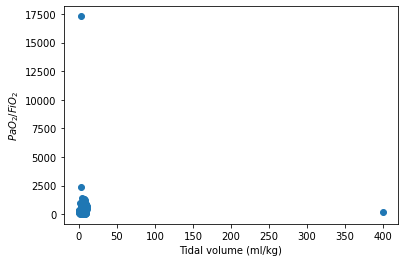

In [34]:
import matplotlib.pyplot as plt
plt.scatter(np.array(all_data)[:,1],np.array(all_data)[:,0])
plt.xlabel('Tidal volume (ml/kg)')
plt.ylabel('$PaO_2/FiO_2$')
plt.show()

### Store data

In [35]:
for i in [structural_features, treatment_dict, outcome_dict, stay_start]:
    del i
def write_csv(outpath, data):
    with open(outpath, 'w',newline='') as file:
        writer = csv.writer(file, delimiter=',')
        writer.writerows(data)
file = './mimiciv_mv_raw.csv'
write_csv(file, all_data)

### Find unique patient

In [36]:
sepsis_query = '''
select icu.subject_id, ss.stay_id from public.sepsis3 ss join public.icustays icu on 
ss.stay_id=icu.stay_id
'''
sepsis_df = pd.read_sql_query(sepsis_query,conn)
sepsis_dict = {} # {stay_id:subject_id}
n = len(sepsis_df)
for i in range(n):
    subject, stay = list(sepsis_df[['subject_id', 'stay_id']].iloc[i])
    if stay not in sepsis_dict:
        sepsis_dict[stay] = []
    sepsis_dict[stay].append(subject)
    
unique_subject = set()
for i in unique_stay:
    for j in sepsis_dict[i]:
        unique_subject.add(j)
print(('The number of unique subject: ', len(unique_subject)))

('The number of unique subject: ', 1226)
